In [46]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def react_sim(rib_num=1,tRNA_cog=1,repeatAllowed=True,bias=1):
    import numpy as np

    #arbitrarily pick rib_id = 0 as cognate ribosome
    #arbitrarily pick tRNA ids 0 to N as cognate tRNAs
    tRNA_id=np.arange(42)
    
    elong_times = list()
    cog_bind=False;
    sys_t=0
    rxns=0
    
    p_cogRib=[bias*1/42]*tRNA_cog#need to adjust to be actual tRNA/codon distrib weighted
    p_cogRib=np.concatenate((p_cogRib,[1/42]*(42-tRNA_cog)))
    p_cogRib = p_cogRib/sum(p_cogRib)
    
    p_noncogRib=[1/(42*bias)]*tRNA_cog 
    p_noncogRib=np.concatenate((p_noncogRib,[1/42]*(42-tRNA_cog)))
    p_noncogRib=p_noncogRib/sum(p_noncogRib)
    
    ## Randomly pick tRNA to be bound to all ribosomes from all possible tRNA.
    ##Pick tRNA for cognate ribosome
    tRNA_bound=np.random.choice(tRNA_id,1,replace=False,p=p_cogRib)
    tRNA_unbound = [tRNA for tRNA in tRNA_id if tRNA not in tRNA_bound]

    ##Pick tRNA for any other ribosomes (that must be noncognate)
    if rib_num>1:
        tRNA_bound=np.concatenate((tRNA_bound,np.random.choice(tRNA_unbound,rib_num-1,replace=False,p=p_noncogRib[tRNA_unbound]/sum(p_noncogRib[tRNA_unbound]))))
        tRNA_unbound = [tRNA for tRNA in tRNA_id if tRNA not in tRNA_bound]


    
    ## For each ribosome, now with a reacting tRNA, pick an exponential random time until dissociation
    react_time = np.random.exponential(1000/717,rib_num)
    
    ## Dealing with the case of cog tRNA binding to cog ribosome: still a probability that the tRNA unbinds
    if tRNA_bound[0] in np.arange(tRNA_cog) and np.random.uniform(0,1)<1475/(1475+717):
        cog_bind=True
        sys_t+=np.random.exponential(1000/1475)
        return sys_t,rxns
        
    #### Loop while cognate tRNA isn't bound to cognate ribosome successfully
    while not cog_bind:
        ###Find next event (a tRNA unbinding from a ribosome) and jump the system to this time
        next_rib_time = min(react_time)
        next_rib = np.argmin(react_time)
        just_unbound_tRNA = tRNA_bound[next_rib]

        if(next_rib==0):
            rxns+=1
        ##Adjust all pending reaction times by change in system time
        sys_t+= next_rib_time
        react_time = react_time - np.ones(rib_num)*next_rib_time
        
        ##Pick new tRNA to be bound to recently unbound ribosome
        unbound_tRNA_repeattransient = np.concatenate((tRNA_unbound,[just_unbound_tRNA]))
        #print(p)
        #print(unbound_tRNA_repeattransient)
        #print(p[unbound_tRNA_repeattransient])
        #print(np.random.choice(unbound_tRNA_repeattransient,size=1,replace=False,p=p[unbound_tRNA_repeattransient]))

        if repeatAllowed:
            #Need to increase the probability that the cognate will be picked if next_rib=0 here.
            #currently its a random.choice; maybe change to a probability matrix of picking
            #from tRNA_id, and then shift up tRNA_cog by 2x, and all other 41 down by (1/41)/41.
            if next_rib==0:
                next_tRNA = np.random.choice(unbound_tRNA_repeattransient,size=1,replace=False,p=p_cogRib[unbound_tRNA_repeattransient]/sum(p_cogRib[unbound_tRNA_repeattransient]))
            else:
                next_tRNA = np.random.choice(unbound_tRNA_repeattransient,size=1,replace=False,p=p_noncogRib[unbound_tRNA_repeattransient]/sum(p_noncogRib[unbound_tRNA_repeattransient]))
 
        else:
            if next_rib==0:
                next_tRNA = np.random.choice(tRNA_unbound,size=1,replace=False,p=p_cogRib[tRNA_unbound]/sum(p_cogRib[tRNA_unbound]))
            else:
                next_tRNA = np.random.choice(tRNA_unbound,size=1,replace=False,p=p_noncogRib[tRNA_unbound]/sum(p_noncogRib[tRNA_unbound]))


        tRNA_bound[next_rib] = next_tRNA
        tRNA_unbound = [tRNA for tRNA in tRNA_id if tRNA not in tRNA_bound]
        
            
        ##Pick a reaction time for the newly bound tRNA
        react_time[next_rib] = np.random.exponential(1000/717)

        
        ##If tRNA that's newly bound is a cog tRNA and its bound at the cognate ribosome, see if the cog_binding is successful
        if tRNA_bound[0] in np.arange(tRNA_cog) and next_rib==0:
            if np.random.uniform(0,1)<1475/(1475+717):
                sys_t+=np.random.exponential(1000/1475)
                return sys_t,rxns
                
    return sys_t,rxns

In [47]:
def computeBiasedWeights(bias=1):
    import numpy as np

    ptRNA = [0.0521, 0.0099, 0.0762, 0.0102, 0.0139, 0.0067, 0.0191, 0.0384, 0.0255, 0.0123, 0.0141,\
     0.0757, 0.0343, 0.0699, 0.0102, 0.0557, 0.0717, 0.0151, 0.0107, 0.0307, \
     0.0165, 0.0309, 0.0113, 0.0166, 0.0144, 0.0115, 0.0093, 0.0035, 0.0208, 0.0055, 0.0226, \
     0.0123, 0.0017, 0.0087, 0.0176, 0.0147, 0.0151, 0.0326, 0.0616,0.0203]
    #I think this was calculated by # of molecules per cell from dong et al? double check, ask emma where she got it from
    ptRNA = np.divide(ptRNA,sum(ptRNA))
    
    #Just set up ptRNA for each growth rate. List all the numbers as is from Dong et al, and then divide
    #by the sum of all the numbers. this should give the relative probabilities.

    tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
    "Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
    "Met_m", "Phe", "Pro1", "Pro2", "Pro3", "Sel_Cys", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
    "Thr2", "Thr3", "Thr4", "Trp", "Tyr1pTyr2", "Val1", "Val2ApB"]

    ptRNA_dict = dict(zip(tRNA_tags, ptRNA))

    codons_Ec = ["GGG", "GGA", "GGU", "GGC", "GAG", "GAA", "GAU", "GAC", "GUG", "GUA", "GUU", \
    "GUC", "GCG", "GCA", "GCU", "GCC", "AGG", "AGA", "AGU", "AGC", "AAG", "AAA", \
    "AAU", "AAC", "AUG", "AUA", "AUU", "AUC", "ACG", "ACA", "ACU", "ACC", "UGG", \
    "UGA", "UGU", "UGC", "UAU", "UAC", "UUG", "UUA", "UUU", "UUC", "UCG", "UCA", \
    "UCU", "UCC", "CGG", "CGA", "CGU", "CGC", "CAG", "CAA", "CAU", "CAC", "CUG", \
    "CUA", "CUU", "CUC", "CCG", "CCA", "CCU", "CCC"]

    pcodons_Ec =[0.00483, 0.00272, 0.03847, 0.03579, 0.01665, 0.05335, 0.02436, \
    0.02885, 0.02150, 0.01594, 0.03146, 0.01130, 0.03047, 0.02223, \
    0.02898, 0.01989, 0.00009, 0.00113, 0.00401, 0.01203, 0.01214, \
    0.04464, 0.00984, 0.02808, 0.02247, 0.00093, 0.02148, 0.03685, \
    0.00757, 0.00350, 0.01394, 0.02663, 0.00981, 0.00031, 0.00425, \
    0.00531, 0.01073, 0.01628, 0.00666, 0.00616, 0.01261, 0.02279, \
    0.00608, 0.00391, 0.01318, 0.01120, 0.00176, 0.00133, 0.03126, \
    0.02235, 0.02938, 0.01024, 0.00927, 0.01396, 0.06041, 0.00216, \
    0.00573, 0.00622, 0.02965, 0.00655, 0.00501, 0.00332]
    pcodons_Ec = np.divide(pcodons_Ec,sum(pcodons_Ec))

    pcodon_dict = dict(zip(codons_Ec, pcodons_Ec))

    #Note AUA does not have an assigned tRNA
    codon_dict={'GGG': ['Gly2'], 'GGA': ['Gly2'], 'GGU': ['Gly3'], 'GGC': ['Gly3'], \
    'GAG': ['Glu2'], 'GAA': ['Glu2'], 'GAU': ['Asp1'], 'GAC': ['Asp1'], \
    'GUG': ['Val1'], 'GUA': ['Val1'], 'GUU': ['Val1','Val2ApB'], \
    'GUC': ['Val2ApB'], 'GCG': ['Ala1B'], 'GCA': ['Ala1B'], 'GCU': ['Ala1B'], \
    'GCC': ['Ala2'], 'AGG': ['Arg5'], 'AGA': ['Arg4'], 'AGU': ['Ser3'], \
    'AGC': ['Ser3'], 'AAG': ['Lys'], 'AAA': ['Lys'], 'AAU': ['Asn'], \
    'AAC': ['Asn'], 'AUG': ['Met_m'], 'AUA': [], 'AUU': ['Ile1'], \
    'AUC': ['Ile1'], 'ACG': ['Thr2','Thr4'], 'ACA': ['Thr4'], \
    'ACU': ['Thr1','Thr4','Thr3'], 'ACC': ['Thr3','Thr1'], \
    'UGG': ['Trp'], 'UGA': ['Sel_Cys'], 'UGU': ['Cys'], 'UGC': ['Cys'], \
    'UAU': ['Tyr1pTyr2'], 'UAC': ['Tyr1pTyr2'], 'UUG': ['Leu5','Leu4'], \
    'UUA': ['Leu5'], 'UUU': ['Phe'], 'UUC': ['Phe'], 'UCG': ['Ser1','Ser2'], \
    'UCA': ['Ser1'], 'UCU': ['Ser5','Ser1'], 'UCC': ['Ser5'], 'CGG': ['Arg3'], \
    'CGA': ['Arg2'], 'CGU': ['Arg2'], 'CGC': ['Arg2'], 'CAG': ['Gln2'], \
    'CAA': ['Gln1'], 'CAU': ['His'], 'CAC': ['His'], 'CUG': ['Leu1','Leu3'], \
    'CUA': ['Leu3'], 'CUU': ['Leu2'], 'CUC': ['Leu2'], 'CCG': ['Pro1','Pro3'], \
    'CCA': ['Pro3'], 'CCU': ['Pro2','Pro3'], 'CCC': ['Pro2']}

    cells = 1
    TU = 9500*20
    time = 180
    tRNA_distrib_arr = list()
    codon_count = {}
    codon_time = {}
    codon_time_avg = {}
    codon_time_weighted_avg={}
    codon_count_hist = {}
    codon_count_hist_weighted_avg = np.zeros(42)
    p_codon_tRNA = {}

    for key in codon_dict:
        codon_count[key] = []
        codon_time[key] = []
        codon_time_avg[key] = []
        codon_time_weighted_avg[key]=[]
        codon_count_hist[key]=[]
        p_codon_tRNA[key] = []

    # Construct dictionary that assigns probability of all tRNA specific to a certain codon
    # to that codon (p_codon_tRNA)
    for codon in codon_dict:
        p_codon_tRNA_i = 0
        for tRNA in codon_dict[codon]:
            p_codon_tRNA_i += ptRNA_dict[tRNA]
        p_codon_tRNA[codon].append(p_codon_tRNA_i)

    for cell in range(cells):
        # Generate distribution for cognate tRNA count for each codon
        for i in range(TU):

            #Construct translation unit with random tRNA (weighted by specific tRNA abundances)
            #and 1 random codon (weighted by codon probabilities).
            codon_vox = np.random.choice(codons_Ec, 1)
            cognatetRNA = codon_dict[codon_vox[0]]
            biased_ptRNA = ptRNA.copy()
            for _,tRNA_i in enumerate(cognatetRNA):
                biased_ptRNA[tRNA_tags.index(tRNA_i)]=biased_ptRNA[tRNA_tags.index(tRNA_i)]*bias
            biased_ptRNA = biased_ptRNA/sum(biased_ptRNA)
            tRNA_vox = list(np.random.choice(tRNA_tags,42,p=biased_ptRNA))

            #Count how many cognate tRNA appeared in the translation unit (for given codon) and record in codon_count
            codon_count_i = 0
            for tRNA in codon_dict[codon_vox[0]]:
                codon_count_i += tRNA_vox.count(tRNA)
            codon_count[codon_vox[0]].append(codon_count_i)

        for codon in codon_count:
            #Generate histogram of cognate tRNA counts for each codon
            codon_count_hist[codon] = np.histogram(codon_count[codon], bins=np.arange(0,43))[0]/sum(np.histogram(codon_count[codon], bins=np.arange(0,43))[0])

            #Weight each cognate tRNA histogram by corresponding codon probabilities to generate a weighted distribution of # of cognate tRNA for any given codon
            codon_count_hist_weighted_avg += codon_count_hist[codon]*pcodon_dict[codon]
        p_codon_count_hist_weighted_avg = codon_count_hist_weighted_avg
        return np.array(p_codon_count_hist_weighted_avg)
print(computeBiasedWeights(1))

[2.46782947e-01 2.55983200e-01 1.96049697e-01 1.36087833e-01
 8.52422226e-02 4.52810375e-02 2.18430877e-02 8.74137334e-03
 2.73192804e-03 9.38550712e-04 2.29175554e-04 8.89472887e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [48]:
#Sanity check with 1 ribosome and 42 tRNA cog:
#sim_time = 1.358 = 0.673*(0.678)+0.327(1.4)+0.327(0.673*(0.678)+0.327(1.4))+0.327^2(0.673*(0.678)+0.327(1.4))+0.327^3(0.673*(0.678)+0.327(1.4))+0.327^4(0.673*(0.678)+0.327(1.4))+0.327^5(0.673*(0.678)+0.327(1.4))+0.327^6(0.673*(0.678)+0.327(1.4))=
#reactions: 0.47=0.32+0.32^2+0.32^3+0.32^4+0.32^5+0.32^6+0.32^7+0.32^8+0.32^9

sim_times=list()
rxn_count = list()
for i in range(1000):
    rxn = react_sim(rib_num=1,tRNA_cog=42,bias=1)
    sim_times.append(rxn[0])
    rxn_count.append(rxn[1])
print(np.average(sim_times))
print(np.average(rxn_count))

###Sanity check with 40 ribosomes 1 cognate tRNA:
sim_times=list()
rxn_count = list()
for i in range(100):
    rxn = react_sim(rib_num=40,tRNA_cog=1,bias=2)
    sim_times.append(rxn[0])
    rxn_count.append(rxn[1])
print(np.average(sim_times))
print(np.average(rxn_count))

1.3624383329743401
0.477
36.05230893324743
25.27


In [ ]:
##gr3
####Keep bias at 1 for all caess, and change the weight to be that calculated by the codon/tRNA distrib bias checker
# in biasedtransportreaction.

weight = np.array([2.47410845e-01, 2.55557283e-01, 1.97535025e-01, 1.36492901e-01,
 8.34292441e-02, 4.51026152e-02, 2.17184051e-02, 8.61952394e-03,
 3.06138229e-03, 7.79889323e-04, 2.15411599e-04, 6.75507099e-05,
 9.92429022e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()
sim_time_std_all = list()
for num_rib in [4,8,9,7]:#4,8,9,9,8,7
    sim_time_gr = list()
    sim_time_gr_std=list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        N=5000
        for i in range(N):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=1)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
        sim_time_gr_std.append(np.std(sim_times)**2)
    #print(sim_time_gr)
    #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

print("Simtimes:")
print(sim_time_all)
print(sim_time_std_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

In [27]:
##gr3
weight = np.array([2.47410845e-01, 2.55557283e-01, 1.97535025e-01, 1.36492901e-01,
 8.34292441e-02, 4.51026152e-02, 2.17184051e-02, 8.61952394e-03,
 3.06138229e-03, 7.79889323e-04, 2.15411599e-04, 6.75507099e-05,
 9.92429022e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()
sim_time_std_all = list()
for num_rib in [9]:#4,8,9,9,8,7
    sim_time_gr = list()
    sim_time_gr_std=list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        N=1000
        for i in range(N):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=3.5)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
        sim_time_gr_std.append(np.std(sim_times)**2)
    #print(sim_time_gr)
    #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

print("Simtimes:")
print(sim_time_all)
print(sim_time_std_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

13.24522257034733
Simtimes:
[13.24522257034733]
[0.18226772564642324]


In [25]:
##gr3
weight = np.array([2.47410845e-01, 2.55557283e-01, 1.97535025e-01, 1.36492901e-01,
 8.34292441e-02, 4.51026152e-02, 2.17184051e-02, 8.61952394e-03,
 3.06138229e-03, 7.79889323e-04, 2.15411599e-04, 6.75507099e-05,
 9.92429022e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()
sim_time_std_all = list()
for num_rib in [4,8,9,7]:#4,8,9,9,8,7
    sim_time_gr = list()
    sim_time_gr_std=list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        N=1000
        for i in range(N):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=1.2)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
        sim_time_gr_std.append(np.std(sim_times)**2)
    #print(sim_time_gr)
    #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

print("Simtimes:")
print(sim_time_all)
print(sim_time_std_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

41.11061914867704


KeyboardInterrupt: 

In [14]:
for bias in np.arange(1,40,0.5):
    print('bias: ',bias)
    weight = computeBiasedWeights(bias)
    print(weight)
    sim_time_all = list()
    sim_time_std_all = list()
    for num_rib in [4,8,9,7]:#4,8,9,9,8,7
        sim_time_gr = list()
        sim_time_gr_std=list()
        rxn_count_gr = list()
        for num_tRNA in np.arange(1,7):
            sim_times=list()
            rxn_count = list()
            N=1000
            for i in range(N):
                rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=1)
                sim_times.append(rxn[0])
                rxn_count.append(rxn[1])
            sim_time_gr.append(np.average(sim_times))
            rxn_count_gr.append(np.average(rxn_count))
            sim_time_gr_std.append(np.std(sim_times)**2)
        #print(sim_time_gr)
        #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
        print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
        sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
        sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

    print("Simtimes:")
    print(sim_time_all)
    print(sim_time_std_all)
    #Need to scale each by proper weight now
    #Note, double tRNA gives actually double the speed this time, since no effects of space.

bias:  1.0
[2.45397801e-01 2.56088653e-01 1.95603069e-01 1.37898130e-01
 8.49120532e-02 4.59007129e-02 2.13065256e-02 9.02135255e-03
 2.68906156e-03 8.89245924e-04 1.81107096e-04 8.51015849e-05
 1.99702479e-05 7.21666129e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
50.22368408191915
50.47305494437037
50.81406507657633
48.499956306194015
Simtimes:
[50.22368408191915, 50.47305494437037, 50.81406507657633, 48.499956306194015]
[0.6875456035814044, 0.6974187181414231, 0.7341837972294174, 0.673678071077526]
bias:  1.5
[1.56390911e-01 2.01330814e-01 1.76839845e-01 1.45821694e-01
 1.16359627e-01 8.42542332e-02 5.8

12.784279231024087
12.671016000853243
12.985339174878561
12.922371641449983
Simtimes:
[12.784279231024087, 12.671016000853243, 12.985339174878561, 12.922371641449983]
[0.2810307953380986, 0.27918003581319273, 0.3090988681790852, 0.29382567797272224]
bias:  6.0
[1.16197632e-02 3.41545280e-02 5.81981944e-02 7.24401981e-02
 7.62634944e-02 7.18695977e-02 6.69434874e-02 6.10219857e-02
 5.93085310e-02 5.86812936e-02 5.85604641e-02 5.76018595e-02
 5.98484572e-02 5.79446827e-02 5.24697728e-02 4.32931147e-02
 3.40952371e-02 2.61425181e-02 1.69483582e-02 1.06501607e-02
 6.13209435e-03 3.00514059e-03 1.60910293e-03 7.83879069e-04
 2.12081732e-04 1.47087346e-04 5.49155372e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
11.418422099912835
11.33580523111245
11.55605853611519
11.331057971567338
Simtimes:
[11.418422099

[2.41707593e-03 6.92226696e-03 1.74620960e-02 3.10901228e-02
 4.27503577e-02 5.04457013e-02 5.41937908e-02 5.35943268e-02
 5.11396287e-02 4.71319664e-02 4.63097400e-02 4.46319160e-02
 4.27457822e-02 4.29814418e-02 4.57572146e-02 4.66218481e-02
 4.84452613e-02 5.19594020e-02 5.15292506e-02 4.95632321e-02
 4.59030155e-02 3.87992693e-02 2.96366589e-02 2.34085369e-02
 1.54188599e-02 8.57512640e-03 5.22705352e-03 3.09367561e-03
 1.40195483e-03 4.48570317e-04 2.97548673e-04 6.89767984e-05
 0.00000000e+00 4.21553090e-07 2.79094464e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4.698684544377097
4.708212657553901
4.638361702126903
4.611364814695204
Simtimes:
[4.698684544377097, 4.708212657553901, 4.638361702126903, 4.611364814695204]
[0.14910472870328295, 0.15252424179639387, 0.14457630901890736, 0.14484679216779958]
bias:  11.0
[2.03796919e-03 5.59747653e-03 1.49171685e-02 2.78761126e-02
 4.03145573e-02 4.70463093e-02 5.19333973

KeyboardInterrupt: 

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. ])

In [10]:
##gr3
weight = np.array([2.47410845e-01, 2.55557283e-01, 1.97535025e-01, 1.36492901e-01,
 8.34292441e-02, 4.51026152e-02, 2.17184051e-02, 8.61952394e-03,
 3.06138229e-03, 7.79889323e-04, 2.15411599e-04, 6.75507099e-05,
 9.92429022e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()
sim_time_std_all = list()
for num_rib in [4,8,9,7]:#4,8,9,9,8,7
    sim_time_gr = list()
    sim_time_gr_std=list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        N=1000
        for i in range(N):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=6)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
        sim_time_gr_std.append(np.std(sim_times)**2)
    #print(sim_time_gr)
    #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

print("Simtimes:")
print(sim_time_all)
print(sim_time_std_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

8.785476998432637
8.6454593095329
8.409456699138984
8.41079769309232
Simtimes:
[8.785476998432637, 8.6454593095329, 8.409456699138984, 8.41079769309232]
[0.12268763345646935, 0.12308328753079814, 0.11890862354429235, 0.11726454199708776]


In [12]:
##gr3
weight = np.array([2.47410845e-01, 2.55557283e-01, 1.97535025e-01, 1.36492901e-01,
 8.34292441e-02, 4.51026152e-02, 2.17184051e-02, 8.61952394e-03,
 3.06138229e-03, 7.79889323e-04, 2.15411599e-04, 6.75507099e-05,
 9.92429022e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()
sim_time_std_all = list()
for num_rib in [4,8,9,7]:#4,8,9,9,8,7
    sim_time_gr = list()
    sim_time_gr_std=list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        N=1000
        for i in range(N):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=7)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
        sim_time_gr_std.append(np.std(sim_times)**2)
    #print(sim_time_gr)
    #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

print("Simtimes:")
print(sim_time_all)
print(sim_time_std_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

7.804211734800054
7.121376159614998
7.208809584285597
7.216240333106053
Simtimes:
[7.804211734800054, 7.121376159614998, 7.208809584285597, 7.216240333106053]
[0.11129274994149399, 0.09938189816121458, 0.09944579349373597, 0.0985035245159608]


In [ ]:
##gr3
weight = np.array([2.47410845e-01, 2.55557283e-01, 1.97535025e-01, 1.36492901e-01,
 8.34292441e-02, 4.51026152e-02, 2.17184051e-02, 8.61952394e-03,
 3.06138229e-03, 7.79889323e-04, 2.15411599e-04, 6.75507099e-05,
 9.92429022e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()
sim_time_std_all = list()
for num_rib in [4,8,9,7]:#4,8,9,9,8,7
    sim_time_gr = list()
    sim_time_gr_std=list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        N=1000
        for i in range(N):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=True,bias=7)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
        sim_time_gr_std.append(np.std(sim_times)**2)
    #print(sim_time_gr)
    #print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_std_all.append(np.sqrt(np.sum(sim_time_gr_std*weight[1:len(sim_time_gr)+1]/(1-weight[0])))/np.sqrt(7*N))

print("Simtimes:")
print(sim_time_all)
print(sim_time_std_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, '$Elongation time,\\: \\tau_{elong}\\: (ms)$')

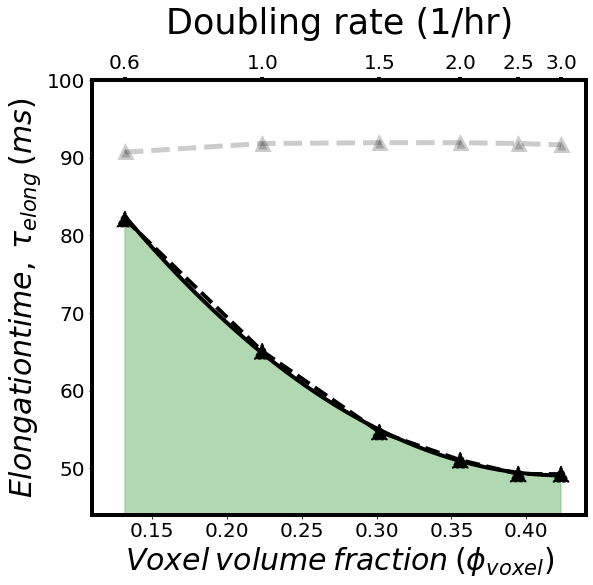

In [39]:
fig, ax = plt.subplots(1,1,figsize=(8.85,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)

ax.plot(x,np.array([49.004400512983324, 50.12212810937539, 50.230189733365265,50.230189733365265,50.12212810937539, 49.95600269442055]
+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='^',markersize=9,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',alpha=0.2,label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])

print(y_hat_sweep_i[-1])

instmix_biased=[40.4064752088474,23.381241263119602,12.985339174878561,9.354347032847222,7.578234613339236,7.5482930465551705]
###Bias amount: [1.5,3,5.5,7,8,8]
instmix_biased_sem=[0.605,0.41,0.31,0.24,0.20,0.20]

ax.scatter(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),zorder=2,s=250,marker='^',color='black',linestyle='dashed')
ax.errorbar(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),instmix_biased_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black')

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(x)
ax1.set_xlabel('Doubling rate (1/hr)',size=35,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_ylim(44,100)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel(r'$Elongation time,\: \tau_{elong}\: (ms)$',size=30,color='black')

86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, '$Elongation time,\\: \\tau_{elong}\\: (ms)$')

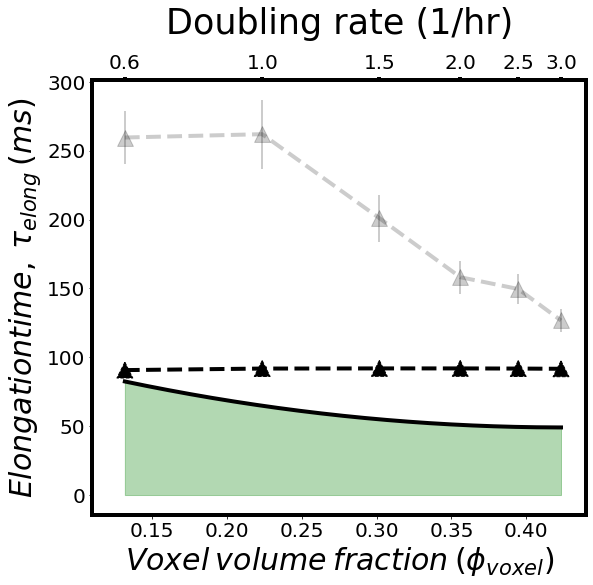

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8.85,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)

instmix_elong=[49.004400512983324, 50.12212810937539, 50.230189733365265,50.230189733365265,50.12212810937539, 49.95600269442055]
instmix_elong_sem=[0.3078632480130797, 0.3088130213708766, 0.31053980811050846,0.31053980811050846,0.3088130213708766, 0.3042957890762189]

ax.scatter(x,instmix_elong+np.array([1000/1529+1000/209+1000/200+1000/32]),zorder=2,s=250,marker='^',color='black',linestyle='dashed')
ax.errorbar(x,instmix_elong+np.array([1000/1529+1000/209+1000/200+1000/32]),instmix_elong_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])
print(y_hat_sweep_i[-1])

elong=[259.5387679125794, 261.9626853605742, 200.99823132492574, 158.14946883794846, 149.5797439370685, 126.7114369897665]

elong_sem=[19.019761433736456, 25.03967369749926, 17.15955904335685, 12.091930180964793, 10.72742391147397, 8.62651849552703]


ax.scatter(x,elong,zorder=2,s=250,marker='^',color='black',alpha=0.2)
ax.errorbar(x,elong,elong_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black',alpha=0.2)

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(x)
ax1.set_xlabel('Doubling rate (1/hr)',size=35,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel(r'$Elongation time,\: \tau_{elong}\: (ms)$',size=30,color='black')

In [16]:
elong_empir = [82.44545311560373, 64.80173984744593, 54.953890127858514, 50.92539189171946, 49.42689484353585, 49.07084465480462]
print(np.divide(elong,[45,45,45,45,45,45]+np.array([1000/1529+1000/209+1000/200+1000/32])))
print(np.divide([45,45,45,45,45,45]+np.array([1000/1529+1000/209+1000/200+1000/32]),elong_empir))
print(np.divide(elong,elong_empir))

[2.76722006 2.78495429 2.15870291 1.70896995 1.60563705 1.3769028 ]
[1.05146746 1.33775284 1.57748088 1.70226891 1.75387735 1.7666032 ]
[2.90964185 3.7255805  3.40531258 2.90912641 2.81609045 2.4324409 ]


In [1]:
3

3

86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, '$Elongation time,\\: \\tau_{elong}\\: (ms)$')

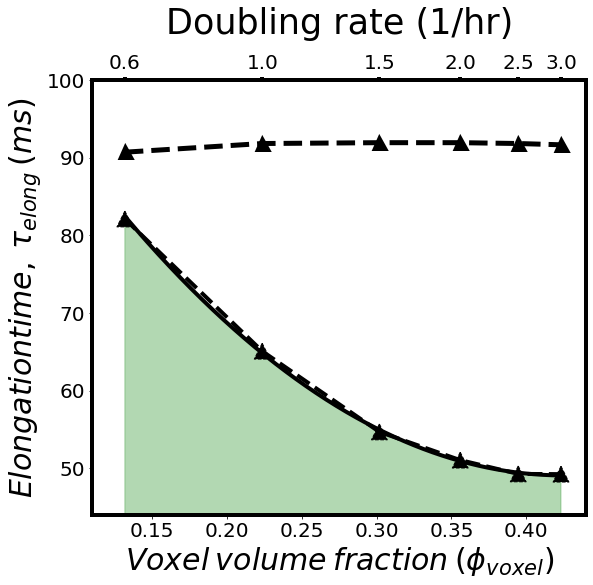

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8.85,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)

bax = brokenaxes(ylims=((44,100), (200, 1)), hspace=.05)


ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)

ax.plot(x,np.array([49.004400512983324, 50.12212810937539, 50.230189733365265,50.230189733365265,50.12212810937539, 49.95600269442055]
+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='^',markersize=9,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',alpha=1.0,label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])

print(y_hat_sweep_i[-1])

instmix_biased=[40.4064752088474,23.381241263119602,12.985339174878561,9.354347032847222,7.578234613339236,7.5482930465551705]
###Bias amount: [1.5,3,5.5,7,8,8]
instmix_biased_sem=[0.605,0.41,0.31,0.24,0.20,0.20]

ax.scatter(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),zorder=2,s=250,marker='^',color='black',linestyle='dashed')
ax.errorbar(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),instmix_biased_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black')

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(x)
ax1.set_xlabel('Doubling rate (1/hr)',size=35,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_ylim(44,100)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel(r'$Elongation time,\: \tau_{elong}\: (ms)$',size=30,color='black')

86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(52.64999999999999, 0.5, '$Elongation time,\\: \\tau_{elong}\\: (ms)$')

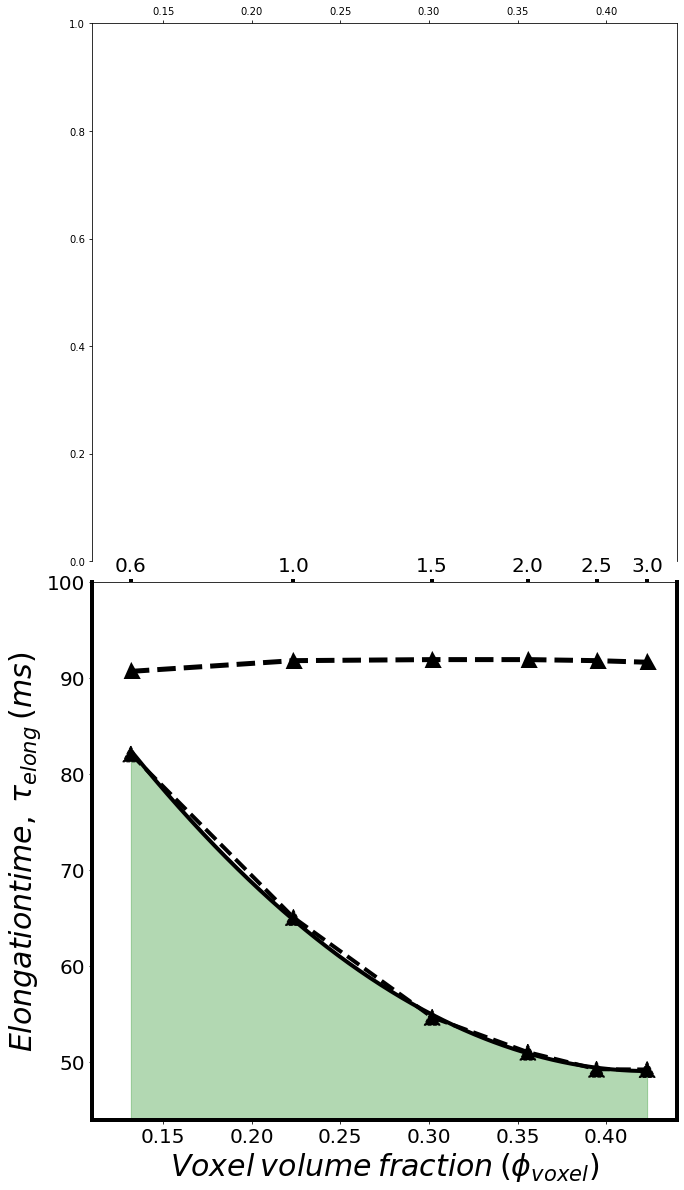

In [27]:
fig, [ax2,ax] = plt.subplots(2,1,figsize=(8.85,16),sharex=True)
ax2.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.xaxis.tick_top()
ax2.tick_params(labeltop='off')  # don't put tick labels at the top
ax.xaxis.tick_bottom()
plt.tight_layout()

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)

ax.plot(x,np.array([49.004400512983324, 50.12212810937539, 50.230189733365265,50.230189733365265,50.12212810937539, 49.95600269442055]
+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='^',markersize=9,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',alpha=1,label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])

print(y_hat_sweep_i[-1])

instmix_biased=[40.4064752088474,23.381241263119602,12.985339174878561,9.354347032847222,7.578234613339236,7.5482930465551705]
###Bias amount: [1.5,3,5.5,7,8,8]
instmix_biased_sem=[0.605,0.41,0.31,0.24,0.20,0.20]

ax.scatter(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),zorder=2,s=250,marker='^',color='black',linestyle='dashed')
ax.errorbar(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),instmix_biased_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black')

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(x)
#ax1.set_xlabel('Doubling rate (1/hr)',size=35,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_ylim(44,100)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel(r'$Elongation time,\: \tau_{elong}\: (ms)$',size=30,color='black')

86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, '$Elongation time,\\: \\tau_{elong}\\: (ms)$')

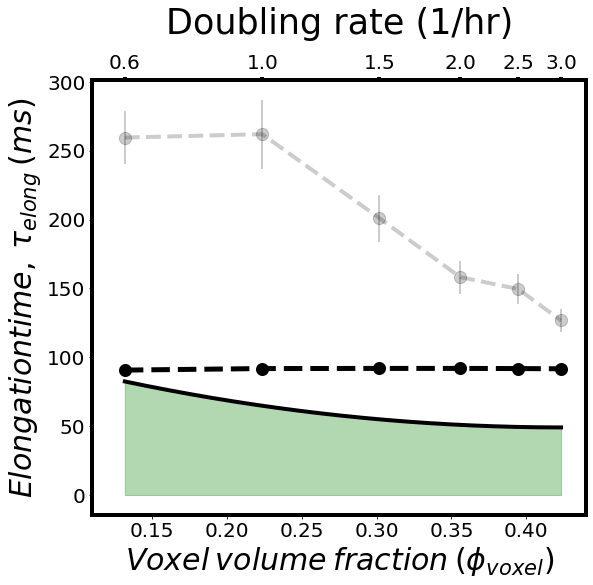

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8.85,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)


elong=[259.5387679125794, 261.9626853605742, 200.99823132492574, 158.14946883794846, 149.5797439370685, 126.7114369897665]

elong_sem=[19.019761433736456, 25.03967369749926, 17.15955904335685, 12.091930180964793, 10.72742391147397, 8.62651849552703]


ax.scatter(x,elong,zorder=2,s=150,marker='o',color='black',alpha=0.2)
ax.errorbar(x,elong,elong_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black',alpha=0.2)



ax.plot(x,np.array([49.004400512983324, 50.12212810937539, 50.230189733365265,50.230189733365265,50.12212810937539, 49.95600269442055]
+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='o',markersize=8,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',alpha=1,label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])

print(y_hat_sweep_i[-1])

instmix_biased=[40.4064752088474,23.381241263119602,12.985339174878561,9.354347032847222,7.578234613339236,7.5482930465551705]
###Bias amount: [1.5,3,5.5,7,8,8]
instmix_biased_sem=[0.605,0.41,0.31,0.24,0.20,0.20]

#ax.scatter(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),zorder=2,s=250,marker='^',color='black',linestyle='dashed')
#ax.errorbar(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),instmix_biased_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black')

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(x)
ax1.set_xlabel('Doubling rate (1/hr)',size=35,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
#ax.set_ylim(0,300)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel(r'$Elongation time,\: \tau_{elong}\: (ms)$',size=30,color='black')


86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, '$Elongation time,\\: \\tau_{elong}\\: (ms)$')

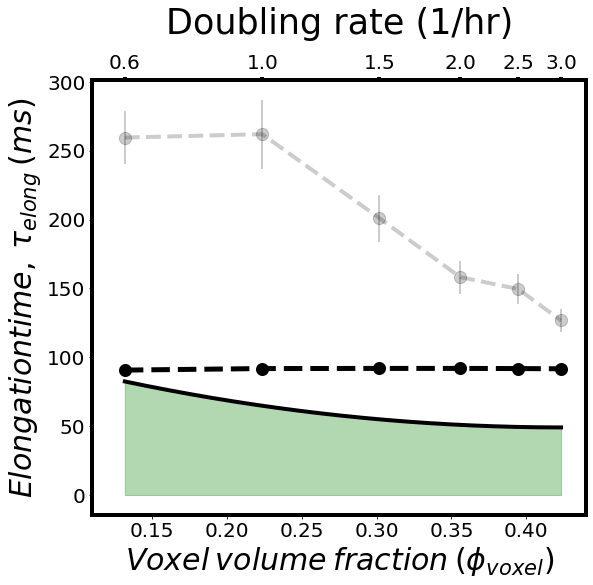

In [65]:
fig, ax = plt.subplots(1,1,figsize=(8.85,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)


elong=[259.5387679125794, 261.9626853605742, 200.99823132492574, 158.14946883794846, 149.5797439370685, 126.7114369897665]

elong_sem=[19.019761433736456, 25.03967369749926, 17.15955904335685, 12.091930180964793, 10.72742391147397, 8.62651849552703]


ax.scatter(x,elong,zorder=2,s=150,marker='o',color='black',alpha=0.2)
ax.errorbar(x,elong,elong_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black',alpha=0.2)


ax.plot(x,np.array([49.004400512983324, 50.12212810937539, 50.230189733365265,50.230189733365265,50.12212810937539, 49.95600269442055]
+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='o',markersize=8,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',alpha=1,label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])

print(y_hat_sweep_i[-1])

instmix_biased=[40.4064752088474,23.381241263119602,12.985339174878561,9.354347032847222,7.578234613339236,7.5482930465551705]
###Bias amount: [1.5,3,5.5,7,8,8]
instmix_biased_sem=[0.605,0.41,0.31,0.24,0.20,0.20]

#ax.plot(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),zorder=2,marker='o',markersize=8,markeredgewidth=5,linewidth=3,linestyle='dashed',color='darkgreen')
#ax.errorbar(x,instmix_biased+np.array([1000/1529+1000/209+1000/200+1000/32]),instmix_biased_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black')

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(x)
ax1.set_xlabel('Doubling rate (1/hr)',size=35,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
#ax.set_ylim(0,300)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel(r'$Elongation time,\: \tau_{elong}\: (ms)$',size=30,color='black')